## Credit Card Fraud Detection

In this project you will predict fraudulent credit card transactions with the help of Machine learning models. Please import the following libraries to get started.

In [34]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import xgboost as xgb

## Exploratory data analysis

In [2]:
df = pd.read_csv('./archive/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Check dimension
df.shape

(284807, 31)

In [ ]:
# Check columns
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## All are float columns except the target which is int
## No missing values in any column

In [ ]:
# Check distribution
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [119]:
df.Class.value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

## We can clearly see that the dataset is highly imbalanced. Only 0.17% of the data are fraud transactions

Here we will observe the distribution of our classes

In [120]:
classes=df['Class'].value_counts()
normal_share=classes[0]/df['Class'].count()*100
fraud_share=classes[1]/df['Class'].count()*100
print(normal_share, fraud_share)

99.82725143693798 0.1727485630620034


[Text(0, 0, '0'), Text(0, 0, '1')]

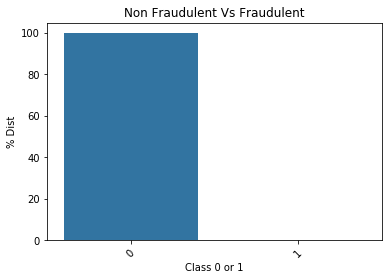

In [ ]:
# Create a bar plot for the number and percentage of fraudulent vs non-fraudulent transcations

dist=df[['Class','Time']].groupby('Class').agg({'Time':'count'}).reset_index()
dist['Time']=dist['Time'].apply(lambda x: 100*x/sum(dist['Time']))
fig1=sns.barplot(data=dist,x='Class',y='Time')
fig1.set(xlabel='Class 0 or 1', ylabel='% Dist',title='Non Fraudulent Vs Fraudulent')
fig1.set_xticklabels(fig1.get_xticklabels(), rotation=45)


In [121]:
# Check statistical dsitribution of features
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

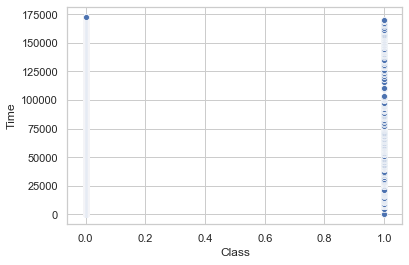

In [ ]:
# Create a scatter plot to observe the distribution of classes with time
sns.set(style='whitegrid')
sns.scatterplot(data=df,y='Time',x='Class')

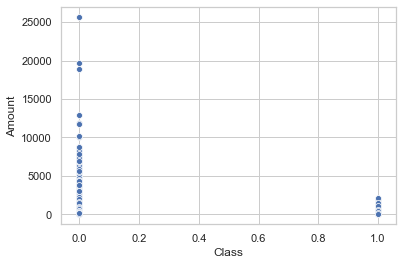

In [ ]:
# Create a scatter plot to observe the distribution of classes with Amount
sns.set(style='whitegrid')
sns.scatterplot(data=df,y='Amount',x='Class')

# We can clearly observe that the fraud transactions are usually in less amounts(less than 4000).

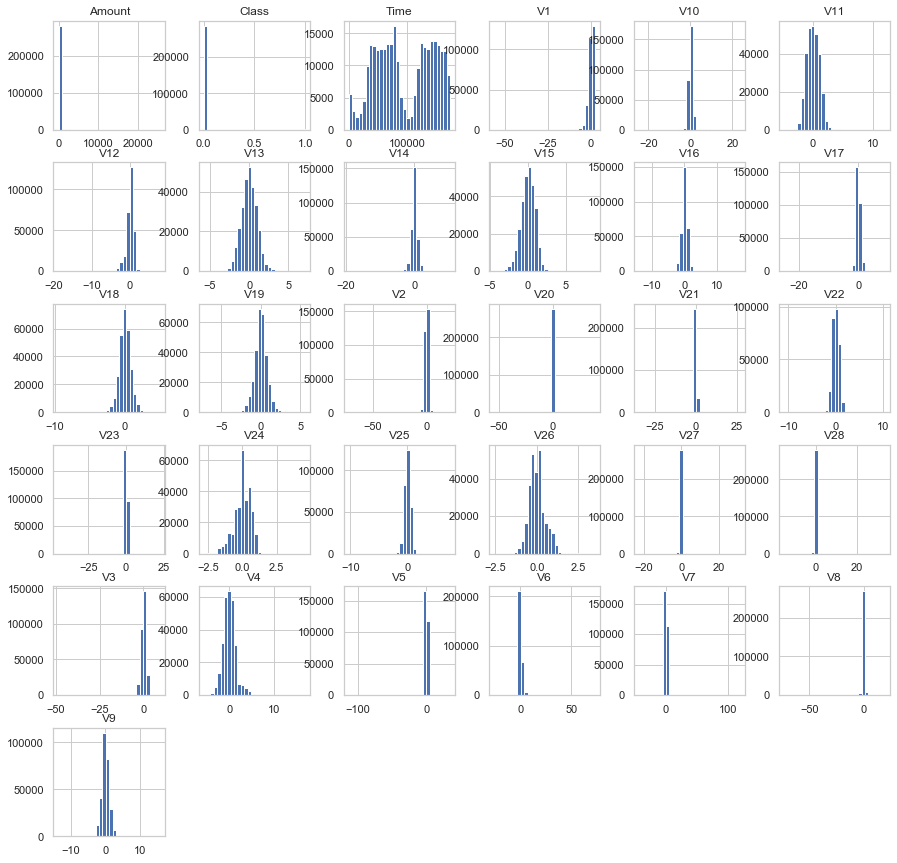

In [ ]:
#Check Skewness

df.hist(bins=30,figsize=(15,15))
plt.show()

## There is no skewness in the features, because they are aleady PCA transformed. All the features show a normal distribution.

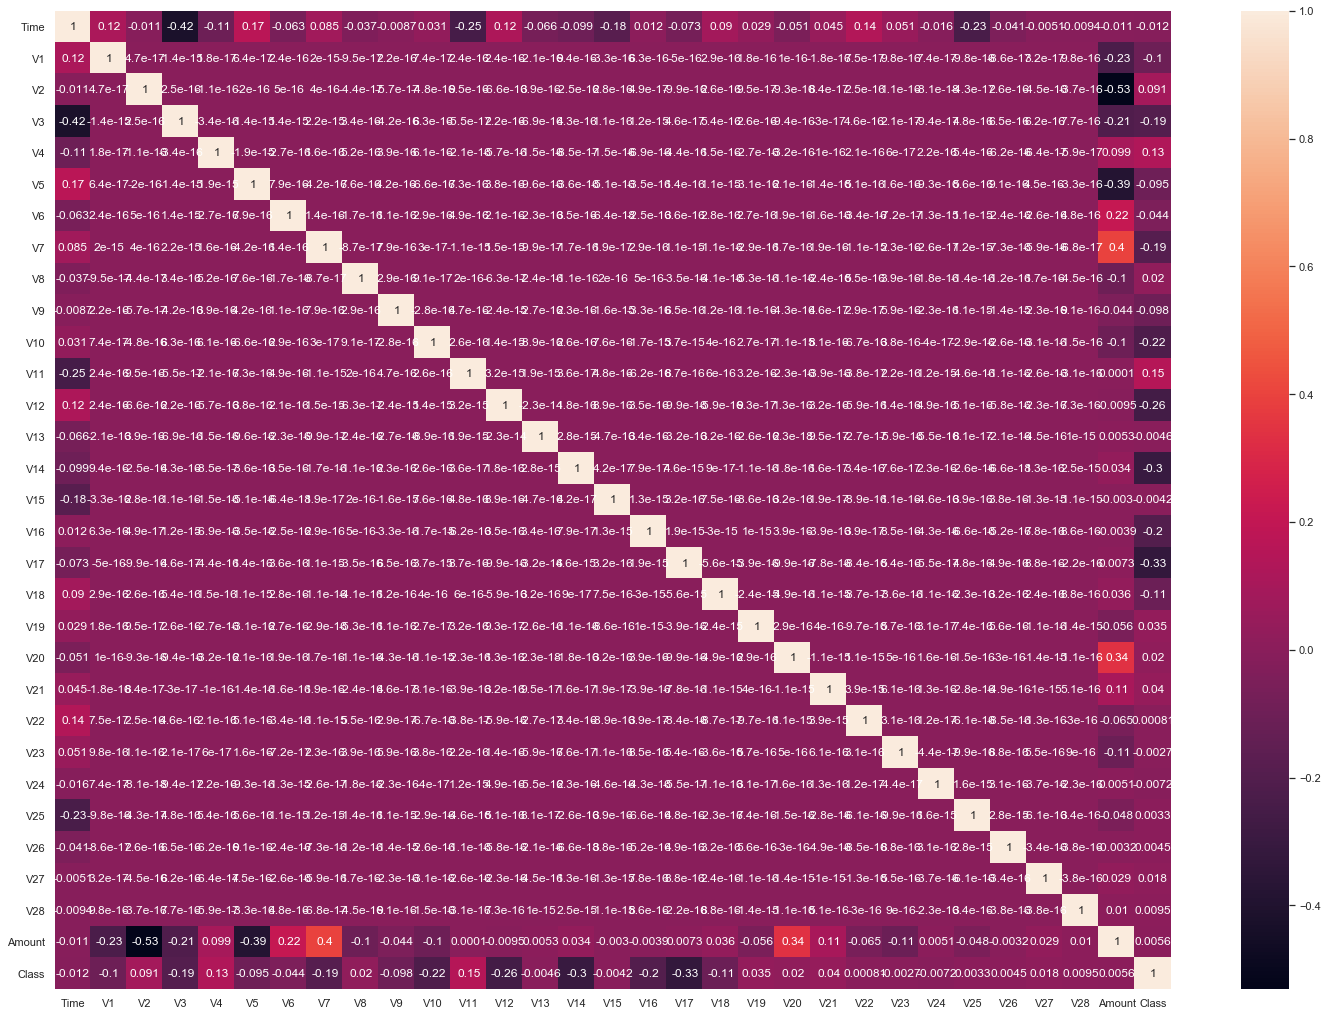

In [ ]:
#See correlation
plt.figure(figsize=(25,18))
sns.heatmap(df.corr(),annot=True)
plt.show()

## Checking Correlation among variables. No high positive or negative correlation found between features.

### Dropping column Time as it does not give any information and is just like an index. 

In [4]:

X=df.drop(columns=['Class','Time'])
Y=df['Class']
print(X.head())
print(Y.head())

         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0  0.098698  0.363787  0.090794  ...  0.251412 -0.018307  0.277838 -0.110474   
1  0.085102 -0.255425 -0.166974  ... -0.069083 -0.225775 -0.638672  0.101288   
2  0.247676 -1.514654  0.207643  ...  0.524980  0.247998  0.771679  0.909412   
3  0.377436 -1.387024 -0.054952  ... -0.208038 -0.108300  0.005274 -0.190321   
4 -0.270533  0.817739  0.753074  ...  0.408542 -0.009431  0.798278 -0.137458   

        V24       V25       V26       V27       V28  Amount  
0  0.0

### Splitting the data into train & test data (70% train and 30% test)

In [5]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = train_test_split(X,Y,stratify=Y,train_size=0.7,test_size=0.3,random_state=100)

##### Preserve X_test & y_test to evaluate on the test data once you build the model

In [6]:
print(np.sum(Y))
print(np.sum(y_train))
print(np.sum(y_test))

492
344
148


In [7]:
#Check distribution in train and test split.

print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

0    0.998275
1    0.001725
Name: Class, dtype: float64
0    0.998268
1    0.001732
Name: Class, dtype: float64


### Plotting the distribution of a variable

In [ ]:
# plot the histogram of a variable from the dataset to see the skewness

### If there is skewness present in the distribution use:
- <b>Power Transformer</b> package present in the <b>preprocessing library provided by sklearn</b> to make distribution more gaussian

In [ ]:
# - Apply : preprocessing.PowerTransformer(copy=False) to fit & transform the train & test data

In [ ]:
# plot the histogram of a variable from the dataset again to see the result 

## There is no skewness in the features, because they are aleady PCA transformed. All the features show a normal distribution.

## Model Building
- Build different models on the imbalanced dataset and see the result

## Trying Decision Tree CLassifier Model
### As there are around 30 features in the dataset, to create a model using all such features will make the model complex and result in overfitting. Hence we are using the Auto Recursive feature selection to reduce the number of features for model building. 

In [63]:

from sklearn.tree import DecisionTreeClassifier

rfe_dt = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=16)

# Fit to the training data
_dt = rfe_dt.fit(X_train, y_train)


In [67]:
# Print the top 16 features
print(_dt.support_)
print(_dt.ranking_)
print(X_train.loc[:,_dt.support_].columns)

[ True False False  True False  True  True False  True  True False  True
 False  True  True  True  True False  True False  True False False False
 False  True  True  True False]
[ 1 13  6  1  8  1  1 11  1  1  4  1  2  1  1  1  1 10  1  7  1 14  9  5
 12  1  1  1  3]
Index(['V1', 'V4', 'V6', 'V7', 'V9', 'V10', 'V12', 'V14', 'V15', 'V16', 'V17',
       'V19', 'V21', 'V26', 'V27', 'V28'],
      dtype='object')


In [74]:
# initiate Decision tree Classifier and Grid SearchCV
dt = DecisionTreeClassifier(random_state = 42)

# Create the parameter grid based on the results of Grid search 
param_grid_dt = {
    'max_leaf_nodes': [10,20,30,40],
    'max_depth': [5,6,7,8],
    'min_samples_split': [8, 10, 12]
}


grid_search_dt = GridSearchCV(estimator = dt,
                           param_grid = param_grid_dt,
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2)

In [75]:
grid_search_dt.fit(X_train.loc[:,_dt.support_], y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8],
                         'max_leaf_nodes': [10, 20, 30, 40],
                         'min_samples_split': [8, 10, 12]},
             verbose=2)

In [76]:
grid_search_dt.best_params_

{'max_depth': 6, 'max_leaf_nodes': 20, 'min_samples_split': 8}

In [90]:
#Build Decision Tree model using best params
dt_model=DecisionTreeClassifier(max_depth=6,
                                max_leaf_nodes=20,
                                min_samples_split=8)

#Train the model using the training sets y_pred=clf.predict(X_test)
dt_model.fit(X_train.loc[:,_dt.support_],y_train)

y_pred_dt=dt_model.predict(X_test.loc[:,_dt.support_])

In [91]:
# Create COnfusion Matrix to calculate metrics

print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_dt))
print('Accuracy: ', accuracy_score(y_test, y_pred_dt))
print('Precision: ', precision_score(y_test, y_pred_dt))
print('Recall: ', recall_score(y_test, y_pred_dt))
auc_dt = metrics.roc_auc_score(y_test, y_pred_dt)
print('AUC: %.3f' % auc_dt)
#Recall has to be as high as possible in our scenario, which is quite low currently.

Confusion Matrix:  [[85278    17]
 [   42   106]]
Accuracy:  0.9993094811745842
Precision:  0.8617886178861789
Recall:  0.7162162162162162
AUC: 0.858


## Recall has to be as high as possible in our scenario, which is quite low currently using Decision tree. Will try more powerfull Random Forest and Gradient Boosting algorithm to see if results are better.

## Decision Tree Imbalanced
### Accuracy:  0.9993094811745842
### Precision:  0.8617886178861789
### Recall:  0.7162162162162162
### AUC: 0.858

In [17]:
# Random Forest model 
#from sklearn import linear_model #import the package
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV




In [79]:
# Feature selection using RFE

rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=16)

# Fit to the training data
_ = rfe.fit(X_train, y_train)

In [80]:
print(_.support_)
print(_.ranking_)


[ True False  True  True False  True  True False  True  True  True  True
 False  True False  True  True  True False False  True False False False
 False  True  True False False]
[ 1  8  1  1  5  1  1  6  1  1  1  1  7  1  3  1  1  1  2  9  1 12 14 11
 13  1  1 10  4]


In [81]:
# initiate Random forest classifier and Grid SearchCV
rf = RandomForestClassifier(random_state = 42)

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 6, 7, 8],
    'max_features': [2, 3],
    'min_samples_leaf': [10, 14, 18],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}


grid_search = GridSearchCV(estimator = rf,
                           param_grid = param_grid,
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2)

In [82]:
X_train.loc[:,_.support_].columns

Index(['V1', 'V3', 'V4', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16',
       'V17', 'V18', 'V21', 'V26', 'V27'],
      dtype='object')

In [83]:
grid_search.fit(X_train.loc[:,_.support_], y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [5, 6, 7, 8],
                         'max_features': [2, 3],
                         'min_samples_leaf': [10, 14, 18],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [84]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 8,
 'max_features': 3,
 'min_samples_leaf': 10,
 'min_samples_split': 8,
 'n_estimators': 200}

In [85]:
#Build Random Forest model using best params
rf_model=RandomForestClassifier(n_estimators=200,
                                min_samples_split=8,
                                min_samples_leaf=10,
                                max_features=3,
                                max_depth=8,
                                bootstrap=True)

In [86]:
#Train the model using the training sets y_pred=clf.predict(X_test)
rf_model.fit(X_train.loc[:,_.support_],y_train)

y_pred=rf_model.predict(X_test.loc[:,_.support_])


In [87]:
# Create COnfusion Matrix to calculate metrics

print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
auc_rf = metrics.roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc_rf)
#Recall has to be as high as possible in our scenario, which is quite low currently.

Confusion Matrix:  [[85281    14]
 [   41   107]]
Accuracy:  0.9993562960102056
Precision:  0.8842975206611571
Recall:  0.722972972972973
AUC: 0.861


## Recall and AUC improved marginally but is still quite low currently using Random Forest on imbalanced data. 

## Random Forest Imbalanced Dataset
### Accuracy:  0.9993562960102056
### Precision:  0.8842975206611571
### Recall:  0.722972972972973
### AUC: 0.861

In [35]:
#pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## Trying XGBoost classifier

In [127]:
# Trying XGBoost algorithm to check the same imbalanced dataset if performing better or not.


rfe_xgb = RFE(estimator=xgb.XGBClassifier(), n_features_to_select=16)
#model = xgb.XGBClassifier()

_xgb = rfe_xgb.fit(X_train, y_train)


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:23:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:24:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:24:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:24:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:25:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:25:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:26:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:26:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:26:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:27:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:27:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:28:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

In [128]:
print(_xgb.support_)
print(_xgb.ranking_)

[ True False  True  True False False  True  True  True  True False  True
 False  True False  True  True  True  True False False False False False
 False  True  True  True False]
[ 1  4  1  1 13 11  1  1  1  1  2  1  7  1  9  1  1  1  1  6  3 12  5 10
 14  1  1  1  8]


In [129]:
# Initialize XGBclassifier and GridsearchCV 
xgb_class=xgb.XGBClassifier()
xgb_params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [ 4, 5],
        'n_estimators': [100,150],
        'learning_rate': [0.05,0.1, 0.2]
        }

grid_search_xgb = GridSearchCV(estimator = xgb_class,
                           param_grid = xgb_params,
                           cv = 3,
                           n_jobs = -1,
                           verbose = 2)

In [131]:
grid_search_xgb.fit(X_train.loc[:,_xgb.support_], y_train)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_

In [132]:
grid_search_xgb.best_params_

{'colsample_bytree': 0.8,
 'gamma': 1,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 150,
 'subsample': 0.8}

In [133]:
# Create XGB model based on the best params from Cross Validation
xgb_model=xgb.XGBClassifier(colsample_bytree=0.8,
                  gamma=1,
                  learning_rate=0.05,
                  max_depth=5,
                  min_child_weight=1,
                  n_estimators=150,
                  subsample=0.8
                 )

#Train the model using the training sets y_pred=clf.predict(X_test)
xgb_model.fit(X_train.loc[:,_xgb.support_],y_train)

y_pred_xgb=xgb_model.predict(X_test.loc[:,_xgb.support_])

[12:06:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [134]:
# Create COnfusion Matrix to calculate metrics


print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_xgb))
print('Accuracy: ', accuracy_score(y_test, y_pred_xgb))
print('Precision: ', precision_score(y_test, y_pred_xgb))
print('Recall: ', recall_score(y_test, y_pred_xgb))

auc_xgb = metrics.roc_auc_score(y_test, y_pred_xgb)
print('AUC: %.3f' % auc_xgb)

Confusion Matrix:  [[85287     8]
 [   29   119]]
Accuracy:  0.9995669627705019
Precision:  0.937007874015748
Recall:  0.8040540540540541
AUC: 0.902


# XGBclassifier is considerably better than Random forest. We can see the Recall has improved from 0.71 to 0.80

## XGBClassifier imbalanced dataset
### Accuracy:  0.9995669627705019
### Precision:  0.937007874015748
### Recall:  0.8040540540540541

### Similarly explore other algorithms by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

#### Proceed with the model which shows the best result 
- Apply the best hyperparameter on the model
- Predict on the test dataset

In [124]:
clf = xgb.XGBClassifier(colsample_bytree=0.8,
                  gamma=1,
                  learning_rate=0.05,
                  max_depth=5,
                  min_child_weight=1,
                  n_estimators=150,
                  subsample=0.8
                 )  #initialise the model with optimum hyperparameters
clf.fit(X_train, y_train)
#print --> #print the evaluation score on the X_test by choosing the best evaluation metric

C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:20:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

### Print the important features of the best model to understand the dataset
- This will not give much explanation on the already transformed dataset
- But it will help us in understanding if the dataset is not PCA transformed

Top var = 17
2nd Top var = 12
3rd Top var = 14


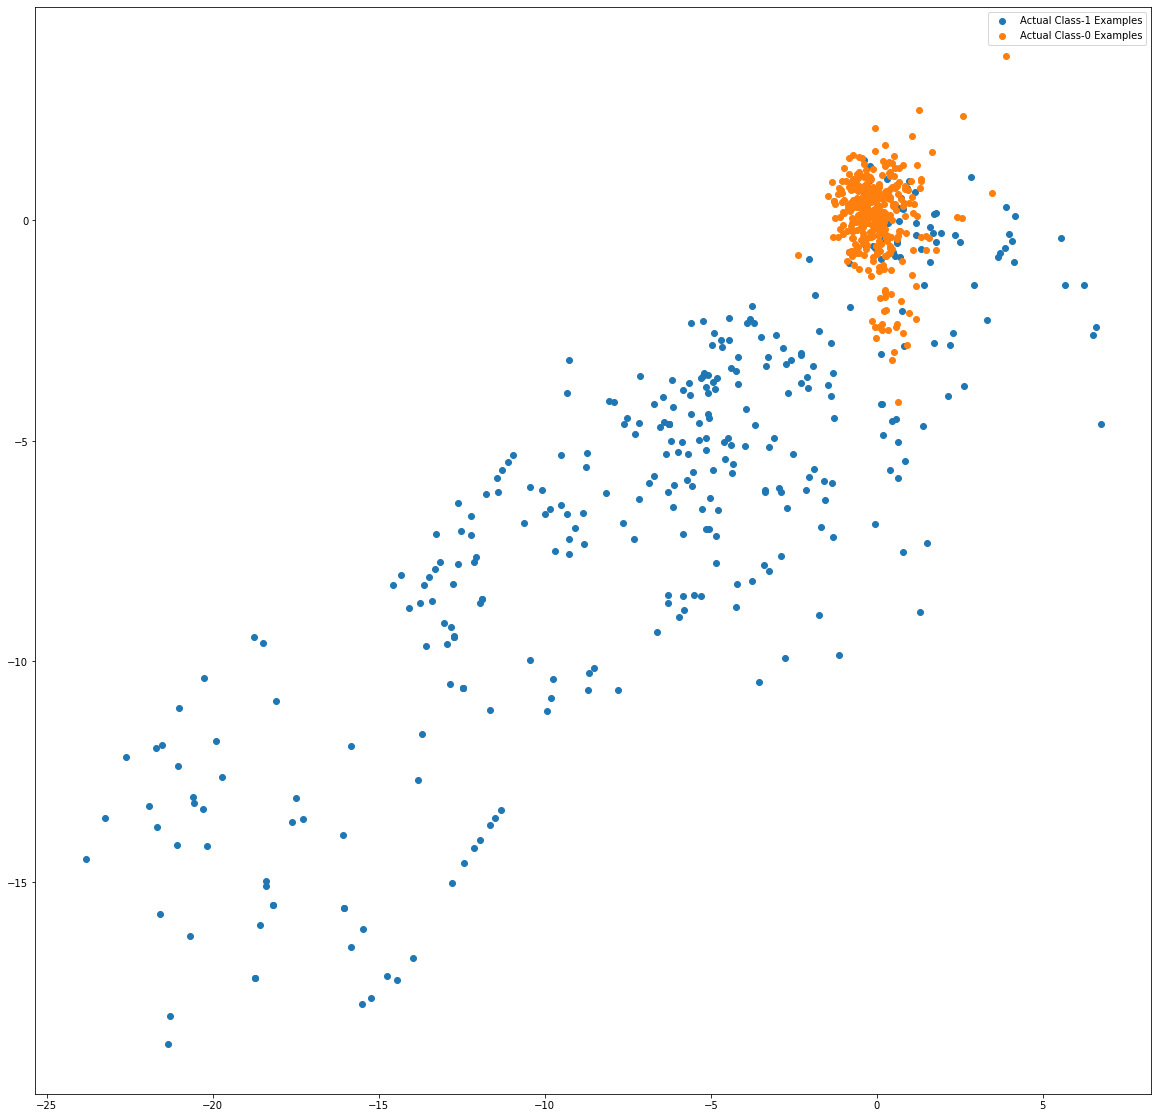

In [125]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-16 and Index-13 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

## Model building with balancing Classes

##### Perform class balancing with :
- Random Oversampling
- SMOTE
- ADASYN

## Model Building
- Build different models on the balanced dataset and see the result

#### perfom cross validation on the X_train & y_train to create:
- X_train_cv
- X_test_cv 
- y_train_cv
- y_test_cv 

### Random Oversampling

In [10]:
pip install imblearn

  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached imbalanced_learn-0.9.0-py3-none-any.whl (199 kB)
Note: you may need to restart the kernel to use updated packages.


In [8]:
 #- import the packages
 # Initiating RandomOverSampler method   
from imblearn.over_sampling import RandomOverSampler
ros=RandomOverSampler(random_state=10)
X_resampled_ros,Y_resampled_ros=ros.fit_resample(X_train,y_train)




In [16]:
print('y_train_original: ',y_train.value_counts())
print('y_train_oversampled: ',Y_resampled_ros.value_counts())
print('X_train_original: ',X_train.shape)
print('X_train_oversampled: ',X_resampled_ros.shape)

y_train_original:  0    199020
1       344
Name: Class, dtype: int64
y_train_oversampled:  0    199020
1    199020
Name: Class, dtype: int64
X_train_original:  (199364, 29)
X_train_oversampled:  (398040, 29)


## Running cross validation using variables derived earlier using RandomForestClassifier
##  On the personal laptop it is taking very long periods to fit the model on this oversampled dataset, hence Using RandomSearchCV as the number of records have increased and GridSearchCV taking too much time to process.

In [26]:

from sklearn.model_selection import RandomizedSearchCV

rf_ros = RandomForestClassifier(random_state = 42)


random_grid_ros = {'n_estimators': [100, 200, 300],
               'max_features': [2, 3],
               'max_depth': [50, 60, 70],
               'min_samples_split': [8, 10, 12],
               'min_samples_leaf': [10, 14, 18],
               'bootstrap': [True]}

rf_random_ros = RandomizedSearchCV(estimator = rf_ros,
                               param_distributions = random_grid_ros,
                               n_iter = 50,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)



### Creating List of Important variables derived from Recursive feature selection, so that we dont have to run RFE everytime. RFE on this dataset is an expensive operation.

In [135]:
dt_var=['V1', 'V4', 'V6', 'V7', 'V9', 'V10', 'V12', 'V14', 'V15', 'V16', 'V17','V19', 'V21', 'V26', 'V27', 'V28']
rfe_var=['V1', 'V3', 'V4', 'V6', 'V7', 'V9', 'V10', 'V11', 'V12', 'V14', 'V16','V17', 'V18', 'V21', 'V26', 'V27']
xgb_var=['V1', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V15', 'V16', 'V17','V18', 'V19', 'V21', 'V26', 'V27', 'Amount']

In [27]:

rf_random_ros.fit(X_resampled_ros[rfe_var], Y_resampled_ros)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [50, 60, 70],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [10, 14, 18],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [28]:
rf_random_ros.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 3,
 'max_depth': 60,
 'bootstrap': True}

In [29]:
#Build Random Forest model using best params
rf_model_ros=RandomForestClassifier(n_estimators=100,
                                min_samples_split=10,
                                min_samples_leaf=10,
                                max_features=3,
                                max_depth=60,
                                bootstrap=True)

In [30]:
#Train the model using the training sets y_pred=clf.predict(X_test)
rf_model_ros.fit(X_resampled_ros[rfe_var],Y_resampled_ros)

y_pred_rf_ros=rf_model_ros.predict(X_test[rfe_var])

In [51]:
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_rf_ros))
print('Accuracy: ', accuracy_score(y_test, y_pred_rf_ros))
print('Precision: ', precision_score(y_test, y_pred_rf_ros))
print('Recall: ', recall_score(y_test, y_pred_rf_ros))
auc_rfe_ros = metrics.roc_auc_score(y_test, y_pred_rf_ros)
print('AUC: %.3f' % auc_rfe_ros)
#Recall(0.82) improved slightly as compared to RandomFOrest model without oversampling ,
#but the Precision dropped considerably.

Confusion Matrix:  [[85264    31]
 [   26   122]]
Accuracy:  0.9993328885923949
Precision:  0.7973856209150327
Recall:  0.8243243243243243
AUC: 0.912


## Creating XGBClassifier model to see performance on Random Over Sampled data

In [35]:
# Running cross validation using variables derived earlier using XGBoost
# Using RandomSearchCV as the number of records have increased and GridSearchCV taking too much time to process.

xgb_class_ros=xgb.XGBClassifier()
xgb_params_ros = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [ 4, 5],
        'n_estimators': [100,150],
        'learning_rate': [0.05,0.1, 10]
        }

xgb_random_ros = RandomizedSearchCV(estimator = xgb_class_ros,
                               param_distributions = xgb_params_ros,
                               n_iter = 50,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

In [37]:
xgb_random_ros.fit(X_resampled_ros[xgb_var], Y_resampled_ros)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:22:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

In [38]:
xgb_random_ros.best_params_

{'subsample': 0.8,
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 1,
 'colsample_bytree': 0.6}

In [41]:
# Create XGB model based on the best params from Cross Validation
xgb_model_ros=xgb.XGBClassifier(colsample_bytree=0.6,
                  gamma=1,
                  learning_rate=0.1,
                  max_depth=5,
                  min_child_weight=1,
                  n_estimators=150,
                  subsample=0.8
                 )

#Train the model using the training sets y_pred=clf.predict(X_test)
xgb_model_ros.fit(X_resampled_ros[xgb_var],Y_resampled_ros)

y_pred_xgb_ros=xgb_model_ros.predict(X_test[xgb_var])

C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:34:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [49]:
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_xgb_ros))
print('Accuracy: ', accuracy_score(y_test, y_pred_xgb_ros))
print('Precision: ', precision_score(y_test, y_pred_xgb_ros))
print('Recall: ', recall_score(y_test, y_pred_xgb_ros))
auc_xgb_ros = metrics.roc_auc_score(y_test, y_pred_xgb_ros)
print('AUC: %.3f' % auc_xgb_ros)

#Recall(0.85) improved slightly as compared to XGBoost model without oversampling ,
#but the Precision dropped considerably.

Confusion Matrix:  [[85260    35]
 [   22   126]]
Accuracy:  0.9993328885923949
Precision:  0.782608695652174
Recall:  0.8513513513513513
AUC: 0.925


# XGBclassifier is considerably better than Random forest. We can see the Recall has improved from 0.82 to 0.85. AUC is also good of 0.925

## Accuracy:  0.9993328885923949
## Precision:  0.782608695652174
## Recall:  0.8513513513513513
## AUC: 0.925


### Similarly explore other algorithms on balanced dataset by building models like:
- KNN
- SVM
- Decision Tree
- Random Forest
- XGBoost

### Applying SMOTE method of oversampling

In [92]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled_smote,Y_resampled_smote = smote.fit_resample(X_train, y_train)



In [93]:
print('y_train_original: ',y_train.value_counts())
print('y_train_oversampled: ',Y_resampled_smote.value_counts())
print('X_train_original: ',X_train.shape)
print('X_train_oversampled: ',X_resampled_smote.shape)

y_train_original:  0    199020
1       344
Name: Class, dtype: int64
y_train_oversampled:  0    199020
1    199020
Name: Class, dtype: int64
X_train_original:  (199364, 29)
X_train_oversampled:  (398040, 29)


## Random forest classifier using SMOTE oversampling

In [94]:
# Running cross validation using variables derived earlier using RandomForestClassifier
# Using RandomSearchCV as the number of records have increased and GridSearchCV taking too much time to process.


rf_smote = RandomForestClassifier(random_state = 42)


random_grid_smote = {'n_estimators': [100, 200, 300],
               'max_features': [2, 3],
               'max_depth': [50, 60, 70],
               'min_samples_split': [8, 10, 12],
               'min_samples_leaf': [10, 14, 18],
               'bootstrap': [True]}

rf_random_smote = RandomizedSearchCV(estimator = rf_smote,
                               param_distributions = random_grid_smote,
                               n_iter = 50,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

In [95]:
rf_random_smote.fit(X_resampled_smote[rfe_var], Y_resampled_smote)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [50, 60, 70],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [10, 14, 18],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [96]:
rf_random_smote.best_params_

{'n_estimators': 100,
 'min_samples_split': 12,
 'min_samples_leaf': 10,
 'max_features': 2,
 'max_depth': 60,
 'bootstrap': True}

In [97]:
#Build Random Forest model using best params
rf_model_smote=RandomForestClassifier(n_estimators=100,
                                min_samples_split=12,
                                min_samples_leaf=10,
                                max_features=2,
                                max_depth=60,
                                bootstrap=True)

In [98]:
#Train the model using the training sets y_pred=clf.predict(X_test)
rf_model_smote.fit(X_resampled_smote[rfe_var],Y_resampled_smote)

y_pred_rf_smote=rf_model_smote.predict(X_test[rfe_var])

In [99]:
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_rf_smote))
print('Accuracy: ', accuracy_score(y_test, y_pred_rf_smote))
print('Precision: ', precision_score(y_test, y_pred_rf_smote))
print('Recall: ', recall_score(y_test, y_pred_rf_smote))
auc_rfe_smote = metrics.roc_auc_score(y_test, y_pred_rf_smote)
print('AUC: %.3f' % auc_rfe_smote)


Confusion Matrix:  [[85241    54]
 [   23   125]]
Accuracy:  0.9990988144142879
Precision:  0.6983240223463687
Recall:  0.8445945945945946
AUC: 0.922


## Recall(0.84) improved slightly as compared to RandomForest model with Random oversampling ,
## but the Precision dropped considerably. AUC showing slight improvement with SMOTE

## XGBClassifier using SMOTE

In [100]:
# Running cross validation using variables derived earlier using XGBoost
# Using RandomSearchCV as the number of records have increased and GridSearchCV taking too much time to process.

xgb_class_smote=xgb.XGBClassifier()
xgb_params_smote = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [ 4, 5],
        'n_estimators': [100,150],
        'learning_rate': [0.05,0.1, 10]
        }

xgb_random_smote = RandomizedSearchCV(estimator = xgb_class_smote,
                               param_distributions = xgb_params_smote,
                               n_iter = 50,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

In [101]:
xgb_random_smote.fit(X_resampled_smote[xgb_var], Y_resampled_smote)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:15:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           reg_alpha=None, reg_lambda=None,
                                           scale_pos_weight=None,
                                       

In [102]:
xgb_random_smote.best_params_

{'subsample': 0.8,
 'n_estimators': 150,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 1,
 'colsample_bytree': 0.6}

In [103]:
# Create XGB model based on the best params from Cross Validation
xgb_model_smote=xgb.XGBClassifier(colsample_bytree=0.6,
                  gamma=1,
                  learning_rate=0.1,
                  max_depth=5,
                  min_child_weight=1,
                  n_estimators=150,
                  subsample=0.8
                 )

#Train the model using the training sets y_pred=clf.predict(X_test)
xgb_model_smote.fit(X_resampled_smote[xgb_var],Y_resampled_smote)

y_pred_xgb_smote=xgb_model_smote.predict(X_test[xgb_var])

[13:41:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [104]:
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_xgb_smote))
print('Accuracy: ', accuracy_score(y_test, y_pred_xgb_smote))
print('Precision: ', precision_score(y_test, y_pred_xgb_smote))
print('Recall: ', recall_score(y_test, y_pred_xgb_smote))
auc_xgb_smote = metrics.roc_auc_score(y_test, y_pred_xgb_smote)
print('AUC: %.3f' % auc_xgb_smote)



Confusion Matrix:  [[85128   167]
 [   22   126]]
Accuracy:  0.9977879990168884
Precision:  0.4300341296928328
Recall:  0.8513513513513513
AUC: 0.925


## Recall(0.85) and AUC (0.925) similar as compared to XGBoost model with random oversampling ,
## but the Precision dropped considerably to (0.43).

## Trying ADASYN oversampling 

In [105]:
#perform cross validation & then balance classes on X_train_cv & y_train_cv using ADASYN
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(random_state=42)
X_resampled_adasyn,Y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

In [106]:
print('y_train_original: ',y_train.value_counts())
print('y_train_oversampled: ',Y_resampled_adasyn.value_counts())
print('X_train_original: ',X_train.shape)
print('X_train_oversampled: ',X_resampled_adasyn.shape)

y_train_original:  0    199020
1       344
Name: Class, dtype: int64
y_train_oversampled:  1    199062
0    199020
Name: Class, dtype: int64
X_train_original:  (199364, 29)
X_train_oversampled:  (398082, 29)


##### Build models on other algorithms to see the better performing on SMOTE

### Print the class distribution after applying ADASYN

## Random Forest Classfier using ADASYN oversampling

In [109]:
# Running cross validation using variables derived earlier using RandomFOrestClassifier
# Using RandomSearchCV as the number of records have increased and GridSearchCV taking too much time to process.


rf_adasyn = RandomForestClassifier(random_state = 42)


random_grid_adasyn = {'n_estimators': [100, 200, 300],
               'max_features': [2, 3],
               'max_depth': [50, 60, 70],
               'min_samples_split': [8, 10, 12],
               'min_samples_leaf': [10, 14, 18],
               'bootstrap': [True]}

rf_random_adasyn = RandomizedSearchCV(estimator = rf_adasyn,
                               param_distributions = random_grid_adasyn,
                               n_iter = 50,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

rf_random_adasyn.fit(X_resampled_adasyn[rfe_var], Y_resampled_adasyn)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [50, 60, 70],
                                        'max_features': [2, 3],
                                        'min_samples_leaf': [10, 14, 18],
                                        'min_samples_split': [8, 10, 12],
                                        'n_estimators': [100, 200, 300]},
                   random_state=42, verbose=2)

In [110]:
rf_random_adasyn.best_params_

{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 18,
 'max_features': 3,
 'max_depth': 70,
 'bootstrap': True}

In [111]:
#Build Random Forest model using best params
rf_model_adasyn=RandomForestClassifier(n_estimators=300,
                                min_samples_split=10,
                                min_samples_leaf=18,
                                max_features=3,
                                max_depth=70,
                                bootstrap=True)

In [112]:
#Train the model using the training sets y_pred=clf.predict(X_test)
rf_model_adasyn.fit(X_resampled_adasyn[rfe_var],Y_resampled_adasyn)

y_pred_rf_adasyn=rf_model_adasyn.predict(X_test[rfe_var])

In [113]:
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_rf_adasyn))
print('Accuracy: ', accuracy_score(y_test, y_pred_rf_adasyn))
print('Precision: ', precision_score(y_test, y_pred_rf_adasyn))
print('Recall: ', recall_score(y_test, y_pred_rf_adasyn))
auc_rfe_adasyn = metrics.roc_auc_score(y_test, y_pred_rf_adasyn)
print('AUC: %.3f' % auc_rfe_adasyn)


Confusion Matrix:  [[85210    85]
 [   23   125]]
Accuracy:  0.998735999438222
Precision:  0.5952380952380952
Recall:  0.8445945945945946
AUC: 0.922


## Recall(0.84) improved slightly as compared to Random Forest model with Random oversampling ,
## but the Precision dropped considerably. AUC showing slight improvement with SMOTE

## XGBoost Classfier using ADASYN

In [114]:
# Running cross validation using variables derived earlier using XGBoost
# Using RandomSearchCV as the number of records have increased and GridSearchCV taking too much time to process.

xgb_class_adasyn=xgb.XGBClassifier()
xgb_params_adasyn = {
        'min_child_weight': [1],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [ 4,6,8,10],
        'n_estimators': [150,200,250],
        'learning_rate': [0.05,0.1, 10],
        'scoring':['f1','recall']
        }

xgb_random_adasyn = RandomizedSearchCV(estimator = xgb_class_adasyn,
                               param_distributions = xgb_params_adasyn,
                               n_iter = 100,
                               cv = 3,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)

In [115]:
xgb_random_adasyn.fit(X_resampled_adasyn[xgb_var], Y_resampled_adasyn)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\sk255209\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:13:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[01:13:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [116]:
xgb_random_adasyn.best_params_

{'subsample': 0.8,
 'scoring': 'recall',
 'n_estimators': 250,
 'min_child_weight': 1,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 1,
 'colsample_bytree': 0.6}

In [117]:
# Create XGB model based on the best params from Cross Validation
xgb_model_adasyn=xgb.XGBClassifier(colsample_bytree=0.6,
                  gamma=1,
                  learning_rate=0.1,
                  max_depth=4,
                  min_child_weight=1,
                  n_estimators=250,
                  subsample=0.8
                 )

#Train the model using the training sets y_pred=clf.predict(X_test)
xgb_model_adasyn.fit(X_resampled_adasyn[xgb_var],Y_resampled_adasyn)

y_pred_xgb_adasyn=xgb_model_adasyn.predict(X_test[xgb_var])

[01:22:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [118]:
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_xgb_adasyn))
print('Accuracy: ', accuracy_score(y_test, y_pred_xgb_adasyn))
print('Precision: ', precision_score(y_test, y_pred_xgb_adasyn))
print('Recall: ', recall_score(y_test, y_pred_xgb_adasyn))
auc_xgb_adasyn = metrics.roc_auc_score(y_test, y_pred_xgb_adasyn)
print('AUC: %.3f' % auc_xgb_adasyn)



Confusion Matrix:  [[84969   326]
 [   23   125]]
Accuracy:  0.9959154055920321
Precision:  0.2771618625277162
Recall:  0.8445945945945946
AUC: 0.920


## Recall(0.84) similar as compared to XGBoost model with random oversampling ,
## but the Precision dropped to very low value of 0.27.

##### Build models on other algorithms to see the better performing on ADASYN

### Select the oversampling method which shows the best result on a model
- Apply the best hyperparameter on the model
- Predict on the test dataset

## The best results we got was from the XGBClassifier using the Random Over Sampling technique. Theoretically it should have been SMOTE/ADASYN which should have given better performance 

## We got the best Recall score, which suggested how many we correctly identified as a Fraud Transaction.

We can see also observe that the F1 score(harmonic mean of precision and recall) will be the best in this case, which is the trade off between the precision and recall.


## Accuracy:  0.9993328885923949
## Precision:  0.782608695652174
## Recall:  0.8513513513513513
## AUC: 0.925

In [140]:
# perform the best oversampling method on X_train & y_train

clf = xgb.XGBClassifier(colsample_bytree=0.6,
                  gamma=1,
                  learning_rate=0.1,
                  max_depth=5,
                  min_child_weight=1,
                  n_estimators=150,
                  subsample=0.8
                 )  #initialise the model with optimum hyperparameters

clf.fit( X_resampled_ros[xgb_var],Y_resampled_ros) # fit on the balanced dataset
#xgb_model_ros.fit(X_resampled_ros[xgb_var],Y_resampled_ros)

y_pred_xgb_ros_final=clf.predict(X_test[xgb_var])

#print the evaluation score on the X_test by choosing the best evaluation metric
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred_xgb_ros_final))
print('Accuracy: ', accuracy_score(y_test, y_pred_xgb_ros_final))
print('Precision: ', precision_score(y_test, y_pred_xgb_ros_final))
print('Recall: ', recall_score(y_test, y_pred_xgb_ros_final))
auc_xgb_ros_final = metrics.roc_auc_score(y_test, y_pred_xgb_ros_final)
print('AUC: %.3f' % auc_xgb_ros_final)

[12:52:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix:  [[85260    35]
 [   22   126]]
Accuracy:  0.9993328885923949
Precision:  0.782608695652174
Recall:  0.8513513513513513
AUC: 0.925


### Print the important features of the best model to understand the dataset

Top var = 7
2nd Top var = 4
3rd Top var = 2


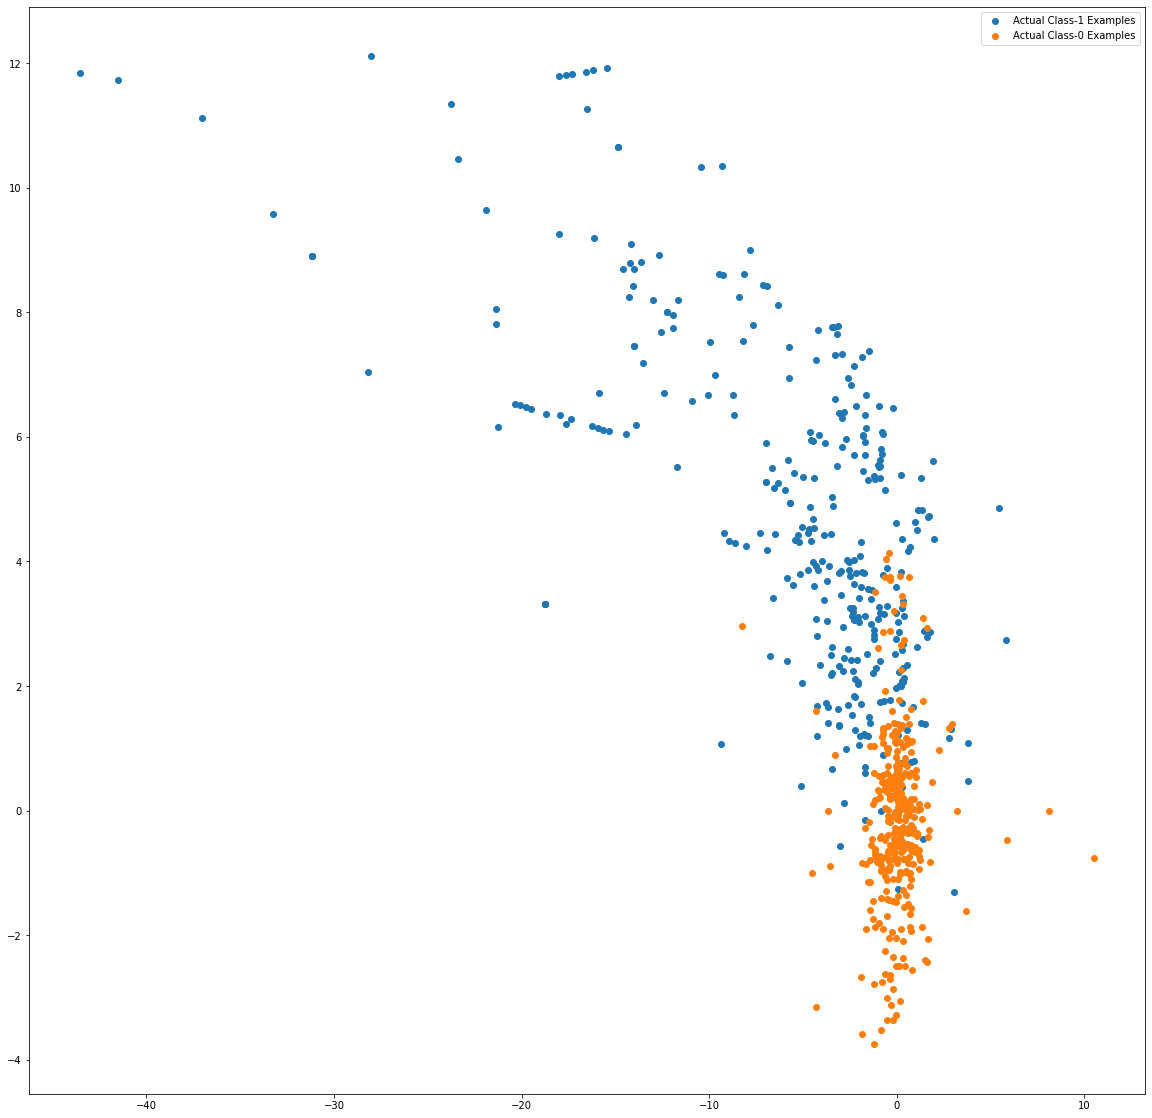

In [141]:
var_imp = []
for i in clf.feature_importances_:
    var_imp.append(i)
print('Top var =', var_imp.index(np.sort(clf.feature_importances_)[-1])+1)
print('2nd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-2])+1)
print('3rd Top var =', var_imp.index(np.sort(clf.feature_importances_)[-3])+1)

# Variable on Index-13 and Index-9 seems to be the top 2 variables
top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-1])
second_top_var_index = var_imp.index(np.sort(clf.feature_importances_)[-2])

X_train_1 = X_train.to_numpy()[np.where(y_train==1.0)]
X_train_0 = X_train.to_numpy()[np.where(y_train==0.0)]

np.random.shuffle(X_train_0)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(X_train_1[:, top_var_index], X_train_1[:, second_top_var_index], label='Actual Class-1 Examples')
plt.scatter(X_train_0[:X_train_1.shape[0], top_var_index], X_train_0[:X_train_1.shape[0], second_top_var_index],
            label='Actual Class-0 Examples')
plt.legend()

In [154]:
#### Print the FPR,TPR & select the best threshold from the roc curve
y_pred_xgb_ros_prob=clf.predict_proba(X_test[xgb_var])[::,1]
y_pred_xgb_ros_prob

array([1.1387598e-03, 3.4308003e-03, 3.2586056e-05, ..., 1.7093390e-04,
       2.3176329e-04, 9.5782387e-05], dtype=float32)

In [160]:
print('AUC =', metrics.roc_auc_score(y_test, y_pred_xgb_ros_final))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_xgb_ros_prob)
threshold = thresholds[np.argmax(tpr-fpr)]
print(threshold)

AUC = 0.9254705053843338
0.0034051957


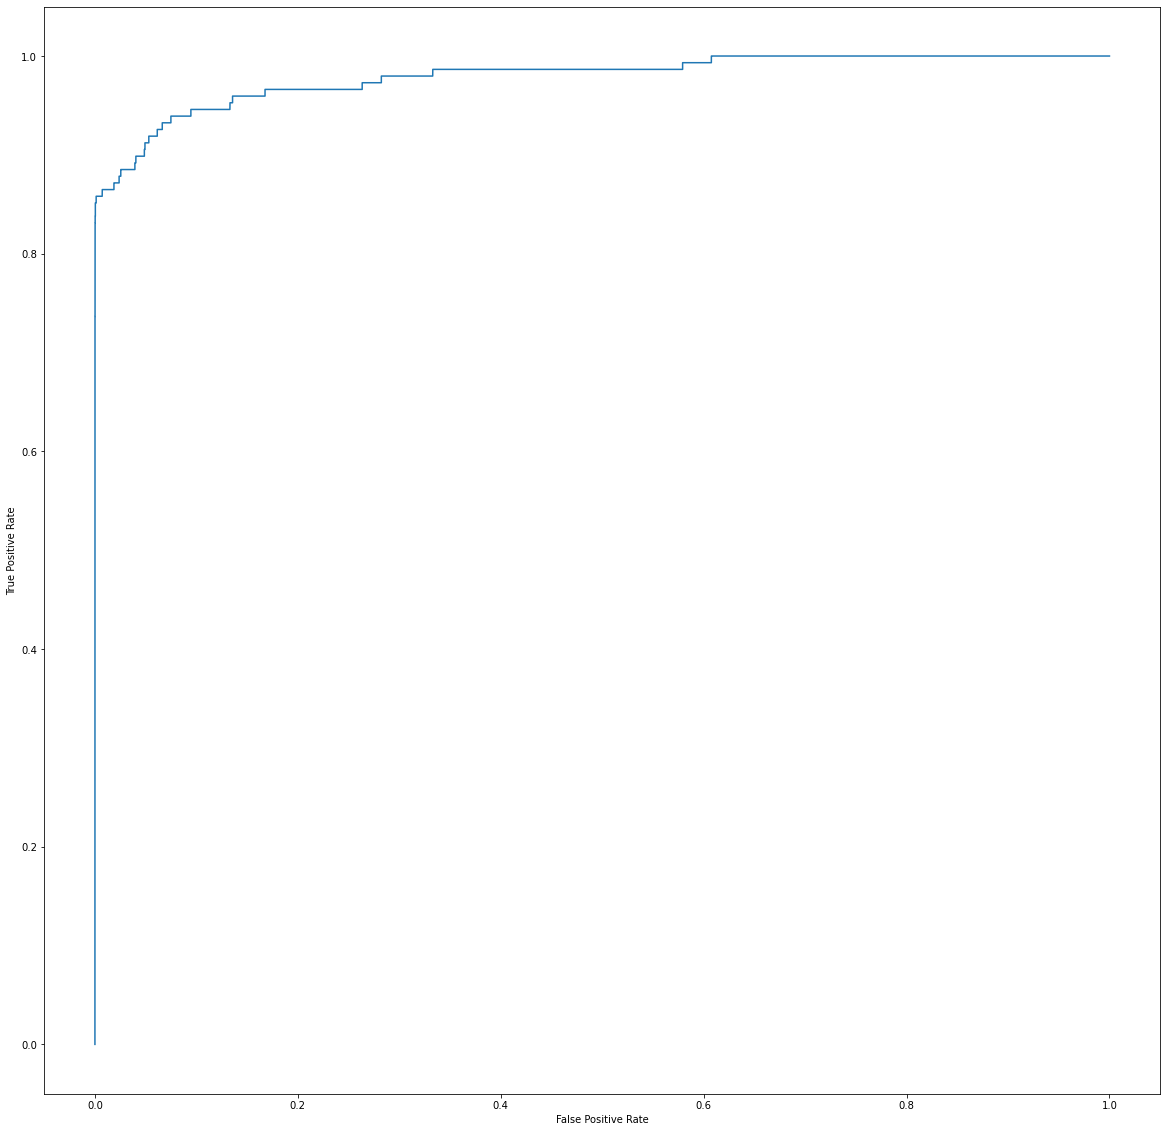

In [156]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()